# Pretrain deep learning

In [63]:
!nvidia-smi

Sun Dec 25 20:45:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 527.56       Driver Version: 527.56       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 43%   45C    P8    41W / 240W |   7642MiB /  8192MiB |     32%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Kutulanmış Lidar Verisinin Okunması

In [64]:
import numpy as np
import matplotlib.pyplot as plt

def readBinDataset(filename):
    binDataset = np.load(filename)
    #print(bin)

    return binDataset

In [65]:
sequence = 0

In [66]:
#windows
binDataset=readBinDataset(r"D:\Ara\numpy_dataset_sequences\%02d_angleBin.npy" % sequence)

# linux
#binDataset=readBinDataset("/mnt/d/Ara/numpy_dataset_sequences/%02d_angleBin.npy" % sequence)

In [67]:
binDataset.shape

(4541, 3601)

In [68]:
binDataset=binDataset.reshape((len(binDataset), 3601,1 ))

In [69]:
binDataset = np.array([ consec_frames for consec_frames in zip(binDataset[0::], binDataset[1::])])

In [70]:
binDataset[0][0], binDataset[0][1]

(array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]),
 array([[ 0.        ],
        [ 0.        ],
        [73.48016344],
        ...,
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]]))

In [71]:
binDataset.shape

(4540, 2, 3601, 1)

In [72]:
plt.rcParams["figure.figsize"] = (15,5.5)

In [73]:
binDataset[0].shape

(2, 3601, 1)

In [74]:
# windows
posePath = "D:\\Ara\\poses\\"
# linux
# posePath = "/mnt/d/Ara/poses/"
poseIdx = "%02d" % sequence
pose = poseIdx + ".txt"

In [75]:
filePath = posePath+pose
file = open(filePath,'r')

In [76]:
def isRotationMatrix(R):
    Rt = np.transpose(R)
    shouldBeIdentity = np.dot(Rt, R)
    I = np.identity(3, dtype=R.dtype)
    n = np.linalg.norm(I - shouldBeIdentity)
    return n < 1e-6

In [77]:
import math
# from scipy.spatial.transform import Rotation as R

def rotationMatrixToEulerAngles(R):
    assert (isRotationMatrix(R))
    sy = math.sqrt(R[0, 0] * R[0, 0] + R[1, 0] * R[1, 0])
    singular = sy < 1e-6

    if not singular:
        x = math.atan2(R[2, 1], R[2, 2])
        y = math.atan2(-R[2, 0], sy)
        z = math.atan2(R[1, 0], R[0, 0])
    else:
        x = math.atan2(-R[1, 2], R[1, 1])
        y = math.atan2(-R[2, 0], sy)
        z = 0

    return np.array([x, y, z])
    r = R.from_matrix(RMat)
    return r.as_euler('xyz')


In [78]:
def get6DoFPose(line):
    rotationTranslation = line.split()
    #print(rotationTranslation)
    
    
    homogenousCoord = np.array(rotationTranslation, dtype=np.float64).reshape((3,4))
    homogenousCoord = np.append(homogenousCoord, [[0,0,0,1]], axis=0)

    #print(homogenousCoord)
    R = homogenousCoord[0:3,0:3]
    pos = homogenousCoord[0:3,3]
    #print(R , pos)
    
    # assert(1==3)

    
    angles = rotationMatrixToEulerAngles(R)

    return np.concatenate((pos, angles)), homogenousCoord

In [79]:
import pykitti
import numpy as np
import math 
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

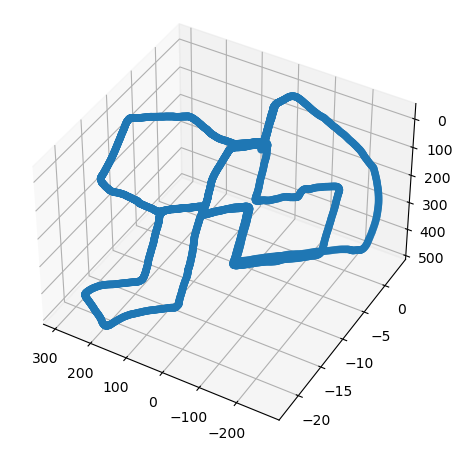

In [80]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

x=np.array([])
y=np.array([])
z=np.array([])
yaw=np.array([])

basedir = 'D:\\dataset\\'
sequence_ = '%02d' % sequence
dataset = pykitti.odometry(basedir, sequence_)
for i in range(len(dataset.poses)):
    x=np.append(x,[dataset.poses[i][0][3]])
    y=np.append(y,[dataset.poses[i][1][3]])
    z=np.append(z,[dataset.poses[i][2][3]])

ax.scatter(x, y, z, marker='o')

t_xyz = np.c_[x,y,z]
ax.view_init(-140, 60)

plt.show()

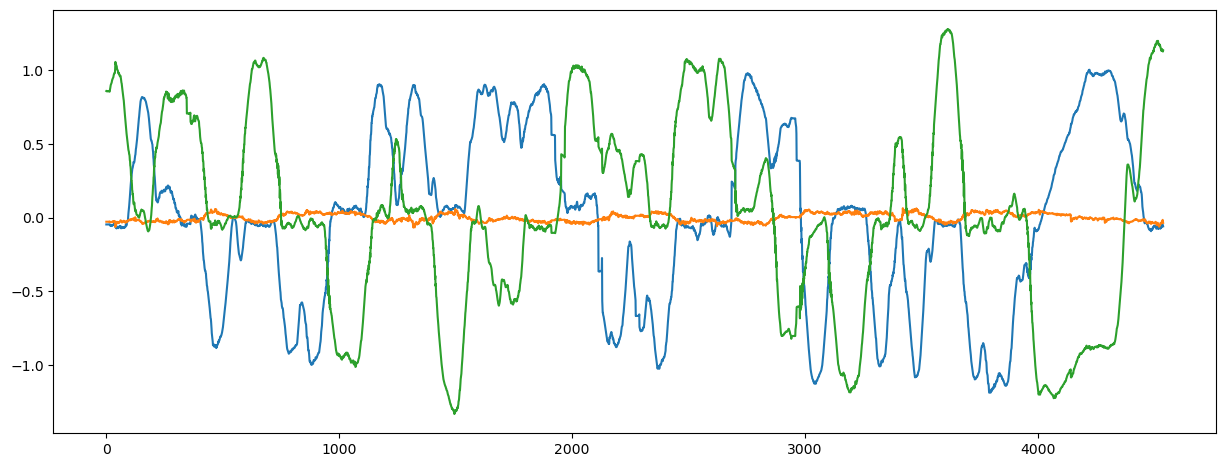

In [81]:
dt_xyz = t_xyz[1:] - t_xyz[0:-1]
plt.plot(dt_xyz)

In [82]:
dt_xz = dt_xyz[:,[0,2]]

0.81988264295328

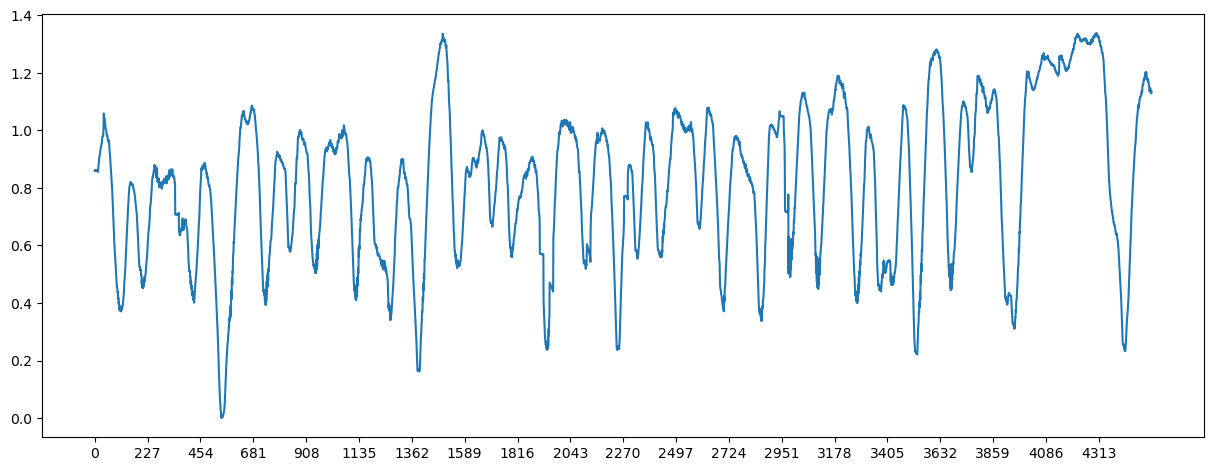

In [83]:
translation = np.sqrt( dt_xz[:,0]** 2 +  dt_xz[:,1]**2)
plt.xticks(range(0, len(translation),int(len(translation)/20)))
plt.plot(translation)
np.mean(translation)

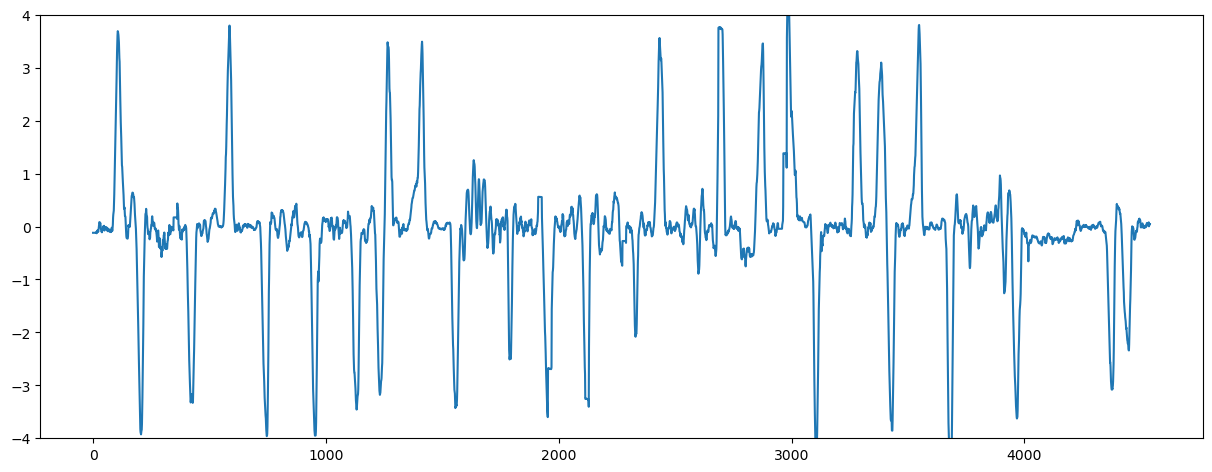

In [84]:
fig1 = plt.figure()
# arrow = plt.axes()
yaw_=np.zeros(len(dataset.poses))
for i in range(len(dataset.poses)):
    r= R.from_matrix([[dataset.poses[i][0][0], dataset.poses[i][0][1], dataset.poses[i][0][2]], [dataset.poses[i][1][0], dataset.poses[i][1][1], dataset.poses[i][1][2]], [dataset.poses[i][2][0], dataset.poses[i][2][1], dataset.poses[i][2][2]]])
    yaw=-r.as_rotvec()[1]
    yaw_[i]=yaw
    # arrow.arrow(x[i], y[i], math.sin(yaw), math.cos(yaw), head_width=0.05, head_length=0.1, fc='k', ec='k')
# plt.plot(np.rad2deg(yaw_))

diff_pitch = (yaw_[1::]-yaw_[:-1:])

# outlier detection
idxs = np.where((diff_pitch>np.deg2rad(300)) | (diff_pitch<np.deg2rad(-300)))

diff_pitch[idxs] =  diff_pitch[idxs] - np.deg2rad(360)  * np.sign(diff_pitch[idxs])

diff_pitch = -diff_pitch
plt.plot((np.rad2deg(diff_pitch)))
plt.ylim([-4, 4])
plt.show()

In [85]:
# len(t_xyz) , len(yaw)

label = np.array((translation,diff_pitch))
label = label.transpose()
binDataset.shape, label.shape

((4540, 2, 3601, 1), (4540, 2))

# Output Çıktısının(translation, rotation) Kutulanması(Örneklenmesi) İşlemi  

In [86]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(label)

label = scaler.transform(label)
scaler.data_max_, scaler.data_min_

(array([1.33764467, 0.07641108]), array([ 0.00037821, -0.08327863]))

In [87]:
def binOutput(label, sample_sz):
    t_bin = np.zeros(sample_sz)
    r_bin = np.zeros(sample_sz)

    interval = sample_sz-1

    t_bin = np.zeros(sample_sz)
    r_bin = np.zeros(sample_sz)
    labelBinned = np.array([[t_bin,r_bin]])
    for data in label:
        t_bin = np.zeros(sample_sz)
        r_bin = np.zeros(sample_sz)
        t_bin[int(((data[0]*interval)))] = 1
        r_bin[int(((data[1]*interval)))] = 1
        
        labelBinned = np.concatenate([labelBinned, np.array([np.array([t_bin, r_bin])])], axis=0)
    return labelBinned[1:]

In [88]:
labelBinned = binOutput(label, 21)

In [89]:
labelBinned.shape, label.shape

((4540, 2, 21), (4540, 2))

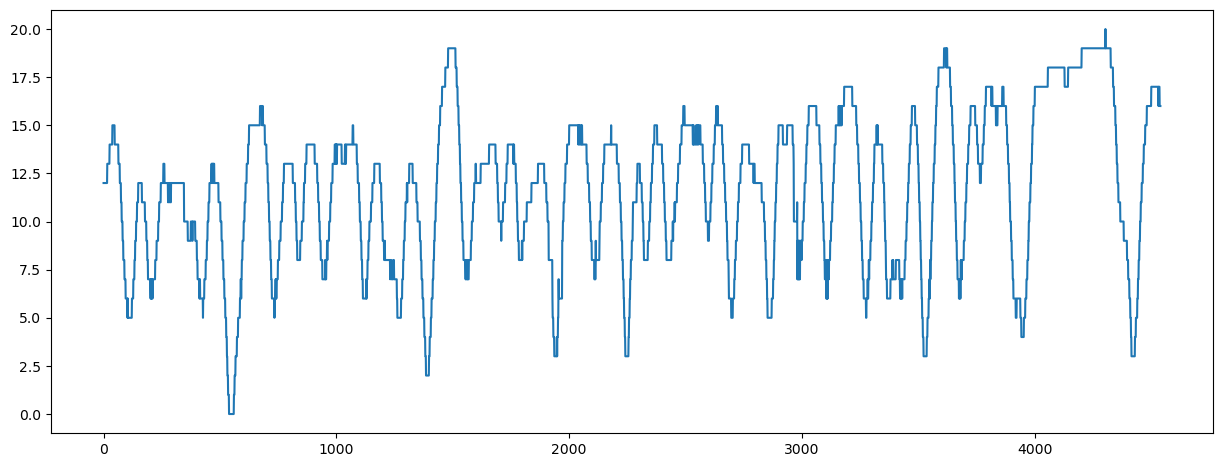

In [90]:
np.where(labelBinned[:,0] > 0)[1]
plt.plot(np.where(labelBinned[:,0] > 0)[1])

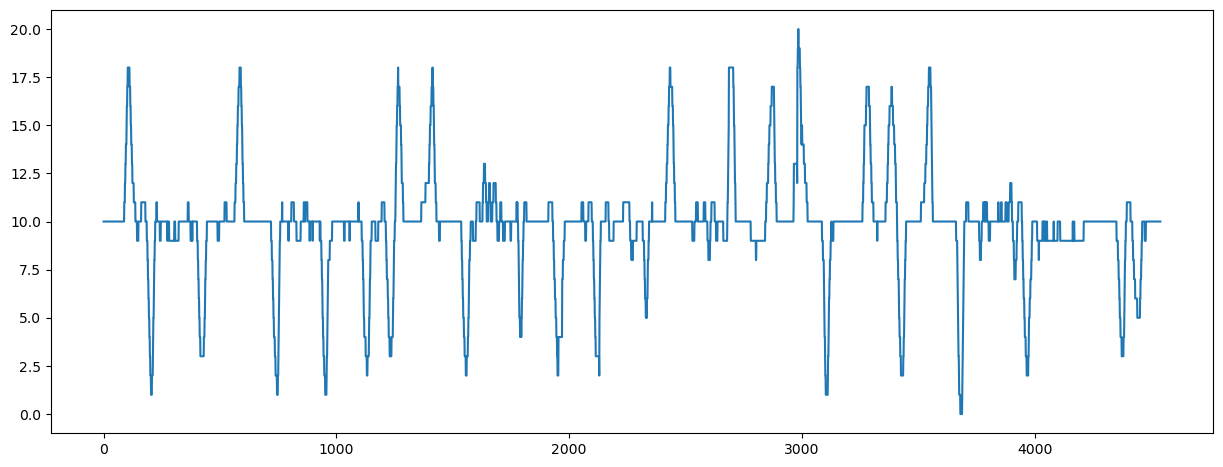

In [91]:
np.where(labelBinned[:,1] > 0)[1].shape
plt.plot(np.where(labelBinned[:,1] > 0)[1])

# Eğitim için gerekli kütüphanelerin getirilmesi ve verilerin tensor matrisi olarak oluşturulması

In [92]:
import tensorflow as tf

In [93]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import concatenate
from keras.layers import TimeDistributed
from keras.layers import LSTM

In [94]:
np.random.seed(16)
tf.random.set_seed(16)

In [95]:
binDataset[:4500].shape , label[:4500].shape, labelBinned[:4500].shape

((4500, 2, 3601, 1), (4500, 2), (4500, 2, 21))

In [96]:
binDataset = binDataset[:4500]
label = label[:4500]
labelBinned = labelBinned[:4500]

In [97]:
binDataset=binDataset.reshape((45,100,2,3601,1))
labelBinned = labelBinned.reshape((45,100,2,21))
# label = label.reshape((110,10,2))

In [98]:
binDataset.shape, labelBinned.shape

((45, 100, 2, 3601, 1), (45, 100, 2, 21))

In [99]:
translation = labelBinned[:,:,0,:]
rotation = labelBinned[:,:,1,:]

In [100]:
translation.shape, rotation.shape

((45, 100, 21), (45, 100, 21))

In [101]:
# with tf.device('/device:GPU:0'):
dataset = tf.data.Dataset.from_tensor_slices((binDataset, {"translation": translation, "rotation" : rotation} ))
# tf.compat.v1.disable_eager_execution()
# data = (binDataset,label)
# a = tf.compat.v1.placeholder(tf.float32,shape=binDataset.shape)
# dataset = tf.data.Dataset.from_tensor_slices(a)
# dataset = dataset.prefetch(buffer_size=1000)
# dataset = dataset.batch(128)
# iterator = tf.compat.v1.data.make_initializable_iterator(dataset)
# next_batch = iterator.get_next()
# with tf.compat.v1.Session() as sess:
#     sess.run(iterator.initializer, feed_dict={a: binDataset})

In [102]:
DATASET_SIZE = len(dataset)
DATASET_SIZE

45

In [103]:
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)
#.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
full_dataset = dataset.shuffle(buffer_size=100).prefetch(buffer_size=tf.data.AUTOTUNE)

train_data = full_dataset.take(train_size).batch(batch_size=4).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = full_dataset.skip(train_size).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = test_data.skip(test_size).batch(batch_size=4).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.take(test_size).batch(batch_size=4).prefetch(buffer_size=tf.data.AUTOTUNE)

In [104]:
train_data, val_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 2, 3601, 1), dtype=tf.float64, name=None), {'translation': TensorSpec(shape=(None, 100, 21), dtype=tf.float64, name=None), 'rotation': TensorSpec(shape=(None, 100, 21), dtype=tf.float64, name=None)})>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 2, 3601, 1), dtype=tf.float64, name=None), {'translation': TensorSpec(shape=(None, 100, 21), dtype=tf.float64, name=None), 'rotation': TensorSpec(shape=(None, 100, 21), dtype=tf.float64, name=None)})>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 2, 3601, 1), dtype=tf.float64, name=None), {'translation': TensorSpec(shape=(None, 100, 21), dtype=tf.float64, name=None), 'rotation': TensorSpec(shape=(None, 100, 21), dtype=tf.float64, name=None)})>)

In [105]:
train_one_sample=train_data.take(1)
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, 100, 2, 3601, 1), dtype=tf.float64, name=None), {'translation': TensorSpec(shape=(None, 100, 21), dtype=tf.float64, name=None), 'rotation': TensorSpec(shape=(None, 100, 21), dtype=tf.float64, name=None)})>

In [106]:
for datum, label in train_one_sample:
  print(f"""
  bin shape: {datum.shape}
  bin dtype: {datum.dtype}
  bin data : {datum}
  translation : {np.where(label['translation'] > 0)[1]}
  rotation : {np.where(label['rotation'] > 0)[1]}
        """)


  bin shape: (4, 100, 2, 3601, 1)
  bin dtype: <dtype: 'float64'>
  bin data : [[[[[45.11891689]
    [46.63683358]
    [ 0.        ]
    ...
    [43.78536948]
    [ 0.        ]
    [44.66943174]]

   [[46.35292153]
    [ 0.        ]
    [46.84285922]
    ...
    [44.7533866 ]
    [ 0.        ]
    [45.57743732]]]


  [[[46.35292153]
    [ 0.        ]
    [46.84285922]
    ...
    [44.7533866 ]
    [ 0.        ]
    [45.57743732]]

   [[45.88312957]
    [47.31280618]
    [ 0.        ]
    ...
    [ 0.        ]
    [45.64990968]
    [ 0.        ]]]


  [[[45.88312957]
    [47.31280618]
    [ 0.        ]
    ...
    [ 0.        ]
    [45.64990968]
    [ 0.        ]]

   [[50.71292871]
    [ 0.        ]
    [50.77689367]
    ...
    [48.32545642]
    [ 0.        ]
    [48.66745028]]]


  ...


  [[[ 0.        ]
    [ 0.        ]
    [ 0.        ]
    ...
    [ 0.        ]
    [ 0.        ]
    [ 0.        ]]

   [[ 0.        ]
    [ 0.        ]
    [ 0.        ]
    ...
    [ 0.        ]


# Temel CNN Ağının Üretilmesi

Bu ağ üzerinde önceden eğitim yapılıp ağırlıklandırılmış olacak sonrasında zamana göre dağıtılmış veriler ile eğitilecek

In [107]:
# Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
model = Sequential([
  Conv1D(filters=32, 
          kernel_size=3, # can also be (3, 3)
          strides=1,
          activation="relu",
          padding="same",
          input_shape=(2, 3601, 1), name="Conv1"), # first layer specifies input shape (height, width, colour channels)
  Conv1D(32, 3, 2,  padding="same",activation="relu", name="Conv2"),
    
  AveragePooling2D(pool_size=(1,3),
                                     strides=(1,3),data_format='channels_last', padding='valid', name="AvgPool"),
  Conv1D(64, 3, 1,  padding="same",activation="relu", name="Conv3"),
  Conv1D(64, 3, 2,  padding="same",activation="relu", name="Conv4"),
  
  AveragePooling2D(pool_size=(1,3),
                                     strides=(1,3),data_format='channels_last', padding='valid', name="AvgPool2"),
  
  Conv1D(128, 3, 1,  padding="same",activation="relu", name="Conv5"),
  Conv1D(128, 3, 2,  padding="same",activation="relu", name="Conv6"),

  AveragePooling2D(pool_size=(1,3),strides=(1,3),data_format='channels_last', padding='valid', name="AvgPool3"),
  
    Flatten(),
  ])

In [110]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv1D)              (None, 2, 3601, 32)       128       
                                                                 
 Conv2 (Conv1D)              (None, 2, 1801, 32)       3104      
                                                                 
 AvgPool (AveragePooling2D)  (None, 2, 600, 32)        0         
                                                                 
 Conv3 (Conv1D)              (None, 2, 600, 64)        6208      
                                                                 
 Conv4 (Conv1D)              (None, 2, 300, 64)        12352     
                                                                 
 AvgPool2 (AveragePooling2D)  (None, 2, 100, 64)       0         
                                                                 
 Conv5 (Conv1D)              (None, 2, 100, 128)      

In [109]:
model.weights # debug

[<tf.Variable 'Conv1/kernel:0' shape=(3, 1, 32) dtype=float32, numpy=
 array([[[-0.06471948,  0.19359273,  0.16340336, -0.16019845,
           0.1417309 , -0.04706949,  0.15976036, -0.21071583,
           0.06511426,  0.12139162,  0.10663483, -0.09729886,
           0.09965774, -0.18683106,  0.16698635, -0.14285272,
          -0.1981944 , -0.10085745,  0.20273301,  0.07272547,
          -0.15051636, -0.04661754,  0.02566949, -0.01582295,
           0.00341432,  0.23042995,  0.06125039,  0.22318298,
           0.0463092 ,  0.09420219,  0.13666877,  0.20278361]],
 
        [[ 0.10646731, -0.22847864, -0.22766301, -0.10391901,
          -0.07493427,  0.11665174,  0.1854124 , -0.21886909,
          -0.03277019, -0.0652661 ,  0.24238563,  0.2115733 ,
           0.20774171, -0.22707883,  0.11063221,  0.01651883,
           0.15994719, -0.1420171 , -0.04813842,  0.22222373,
           0.0925054 ,  0.15815476, -0.21569806,  0.00643298,
           0.01689535,  0.18939707,  0.02277979, -0.222608

# Ana CNN Ağının Zamana Göre Arıtılmış Üretilmesi

In [48]:
input_layer = tf.keras.layers.Input(shape=(None,2,3601,1), ragged=True)
cnn_model = model
# for layer in model.layers:
#     layer._inbound_nodes = []
#     cnn_model = layer(cnn_model)

In [49]:
cnn_model = TimeDistributed(cnn_model)(input_layer)

In [50]:
cnn_model = LSTM(1024,return_sequences=True)(cnn_model)

In [51]:
cnn_model = LSTM(1024, return_sequences=True)(cnn_model)

In [52]:
model1 = Dense(512, activation='relu')(cnn_model)
model2 = Dense(512, activation='relu')(cnn_model)

model1 = Dropout(0.3) (model1)
model2 = Dropout(0.3) (model2)


model1 = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-3))(model1)
model2 = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-3))(model2)

model1 = Dropout(0.2) (model1)
model2 = Dropout(0.2) (model2)

# model1 = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-3))(model1)
# model2 = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-3))(model2)

# model1 = tf.keras.layers.Dropout(0.2) (model1)
# model2 = tf.keras.layers.Dropout(0.2) (model2)

model1 = Dense(21, name="translation",activation='softmax')(model1) # translate
model2 = Dense(21, name="rotation",activation='softmax')(model2) # yaw

# model1 = tf.keras.layers.Activation('softmax', name="translation")(model1)
# model2 = tf.keras.layers.Activation('softmax', name="rotation")(model2)

pre_model = tf.keras.Model(inputs=[input_layer], outputs=[model1, model2])
# losses = {
# 	"translation": CustomAccuracyTranslation(),
# 	"rotation": CustomAccuracyRotation(),
# }
# # losses = {"translation" : "mse", "rotation" : "mse"}
# loss_weights = {'translation' : 1, 'rotation' : 150}
# pre_model.compile(optimizer='adam',  loss=losses,loss_weights=loss_weights, metrics={"translation": ["mse"], "rotation": ["mse"]})
# pre_model.compile(loss = 'binary_crossentropy',
#               optimizer = tf.keras.optimizers.SGD(0.001, momentum=0.9),
#               metrics = ['accuracy'])

In [53]:
pre_model.compile(loss = 'categorical_crossentropy',
              optimizer='adam',
              metrics = ['accuracy'])

In [54]:
pre_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 2, 36  0           []                               
                                01, 1)]                                                           
                                                                                                  
 time_distributed (TimeDistribu  (None, None, 4096)  95776       ['input_1[0][0]']                
 ted)                                                                                             
                                                                                                  
 lstm (LSTM)                    (None, None, 1024)   20975616    ['time_distributed[0][0]']       
                                                                                              

In [55]:
# !conda install graphviz -y
# !conda install pydot -y
# !conda install pydotplus -y

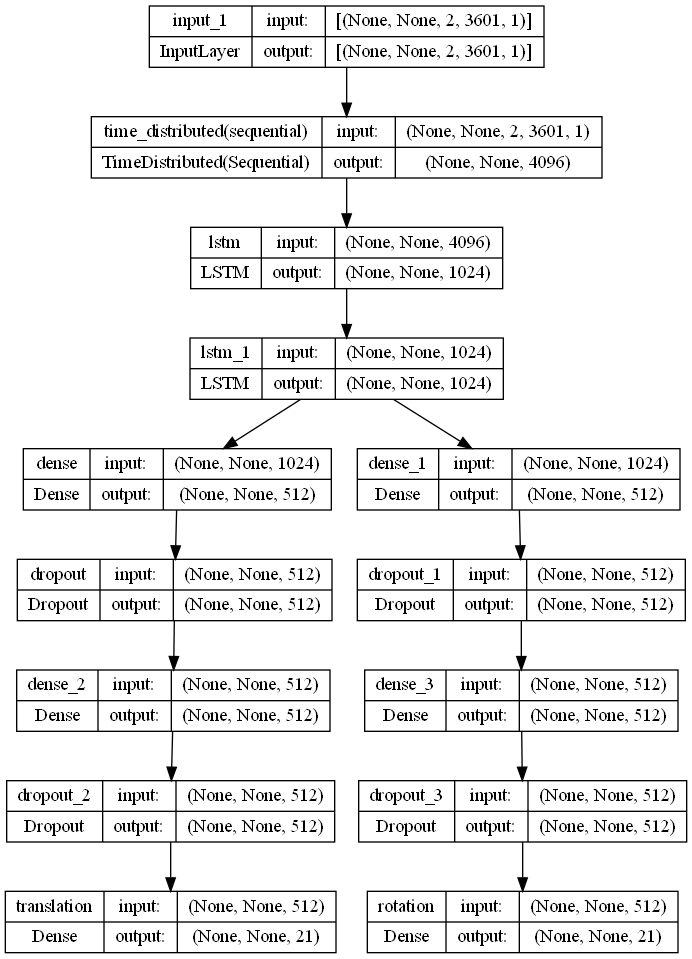

In [57]:
tf.keras.utils.plot_model(pre_model, show_shapes=True)

In [58]:
# train_data, val_data, test_data
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [59]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [60]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2515845940721776037
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5748293632
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5759269609763234576
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

# Tek sequence eğitimi

In [61]:
pre_model.output

[<KerasTensor: type_spec=RaggedTensorSpec(TensorShape([None, None, 21]), tf.float32, 1, tf.int64) (created by layer 'translation')>,
 <KerasTensor: type_spec=RaggedTensorSpec(TensorShape([None, None, 21]), tf.float32, 1, tf.int64) (created by layer 'rotation')>]

In [62]:
pre_model.fit(train_data,
              epochs=1,
            #   validation_data=val_data,
              verbose=1
              #validation_steps=int(0.25 * len(val_data))
              #callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_ext")]
             )

KeyboardInterrupt: 

In [562]:
predictions = pre_model.predict(test_data)

2/2 [==============================] - 2s 71ms/step


In [563]:
prediction_train = pre_model.predict(train_data)

8/8 [==============================] - 1s 99ms/step


# Örnek Batch verisi kontrolü

In [432]:
train_batch = train_data.as_numpy_iterator()

In [433]:
example_trained_data = train_batch.next()

In [434]:
example_trained_data[0].shape # input

(4, 100, 2, 3601, 1)

In [435]:
example_trained_data[1]['translation'].shape, example_trained_data[1]['rotation'].shape

((4, 100, 21), (4, 100, 21))

In [436]:
example_bin_input_time_distributed = example_trained_data[0][0]
example_bin_input_time_distributed.shape
example_bin_output_time_distributed_translation = example_trained_data[1]['translation'][0]
example_bin_output_time_distributed_rotation = example_trained_data[1]['rotation'][0]
example_bin_output_time_distributed_translation[7]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0.])

In [437]:
def plotAngleBin(ax,angleBin):
    ax.cla()
    ax.scatter(0,0)
    xList = []
    yList = []
    for angle, bin in enumerate(angleBin):
        if bin > 0:
            y=bin*np.sin(np.deg2rad(angle*0.1))
            x=bin*np.cos(np.deg2rad(angle*0.1))
            xList.append(x)
            yList.append(y)
            # ax.scatter(x,y)
    ax.scatter(xList,yList)
    plt.pause(0.00000000000001)
    plt.show()

In [438]:
%matplotlib qt
# %matplotlib inline
fig, axs = plt.subplots(2)
axs[0].set_aspect('equal', adjustable='box')
axs[1].set_aspect('equal', adjustable='box')

for i in range(len(example_bin_input_time_distributed)):
    fig.suptitle("Zaman Serisinde Verilen iki resim")
    text = fig.text(0.1, 0.1,"translation:{translation} rotation:{rotation} ".format(translation=np.argmax(example_bin_output_time_distributed_translation[i]), rotation=np.argmax(example_bin_output_time_distributed_rotation[i])))
    plotAngleBin(axs[0], example_bin_input_time_distributed[i][0])
    
    plotAngleBin(axs[1], example_bin_input_time_distributed[i][1])
    text.remove()
    # print(example_bin_input_time_distributed[i][0] == example_bin_input_time_distributed[i][1])


# Modelden elde edilen çıktıların doğruluk kontrolü

In [439]:
prediction_train[1].shape

(31, 100, 21)

In [440]:
len(prediction_train), len(train_data)

(2, 8)

In [441]:
X_train = list(map(lambda x: x[0], train_data))
y_train = list (map(lambda x: x[1], train_data))

In [442]:
X_train[6].shape

TensorShape([4, 100, 2, 3601, 1])

In [443]:
y_train[6]['translation'].shape

TensorShape([4, 100, 21])

In [444]:
prediction_train[0].shape

(31, 100, 21)

In [445]:
tf.concat([i['translation'] for i in y_train], axis=0)[0].shape

TensorShape([100, 21])

In [446]:
np.argmax(tf.concat([i['translation'] for i in y_train], axis=0)[0], axis=1)

array([ 9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 12, 12, 12, 12, 12, 12, 12],
      dtype=int64)

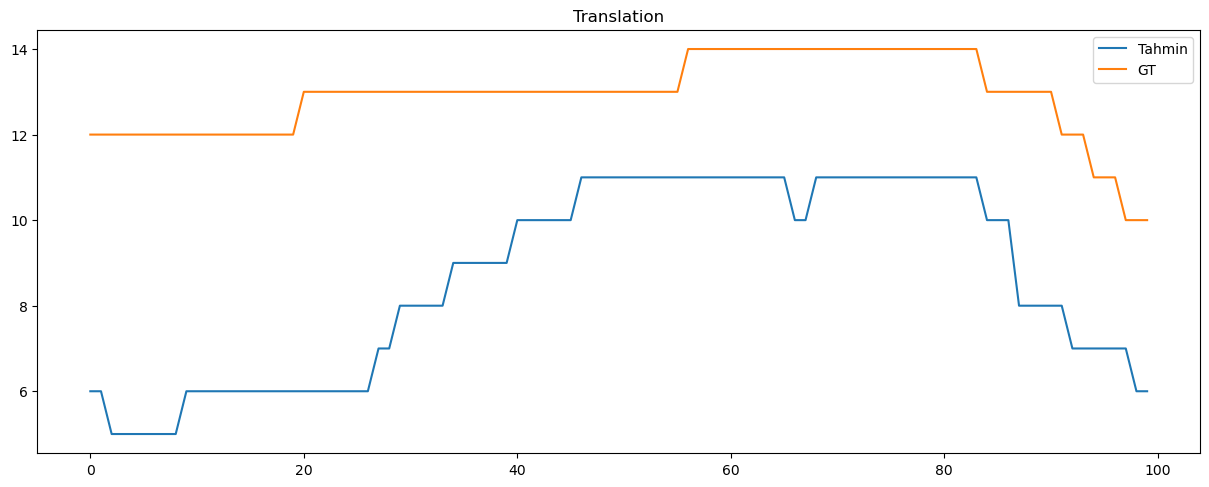

In [447]:
%matplotlib inline
plt.plot(np.argmax(prediction_train[0][30], axis=1),label="Tahmin")
plt.plot(np.argmax(tf.concat([i['translation'] for i in y_train], axis=0)[30], axis=1), label="GT")

plt.title("Translation")
#plt.xlim([0,50])

plt.legend()
plt.show()

In [448]:
prediction_train[0].shape

(31, 100, 21)

In [449]:
%matplotlib qt
ax = plt.axes()

for i in range(prediction_train[0].shape[0]-1):
    ax.cla()
    ax.plot(np.argmax(prediction_train[0][i], axis=1),label="Tahmin")
    ax.plot(np.argmax(tf.concat([i['translation'] for i in y_train], axis=0)[i], axis=1), label="GT")

    ax.set_title("Translation frame : " + str(i))
    #plt.xlim([0,50])

    ax.legend()
    plt.pause(0.0000000000001)
    plt.show()

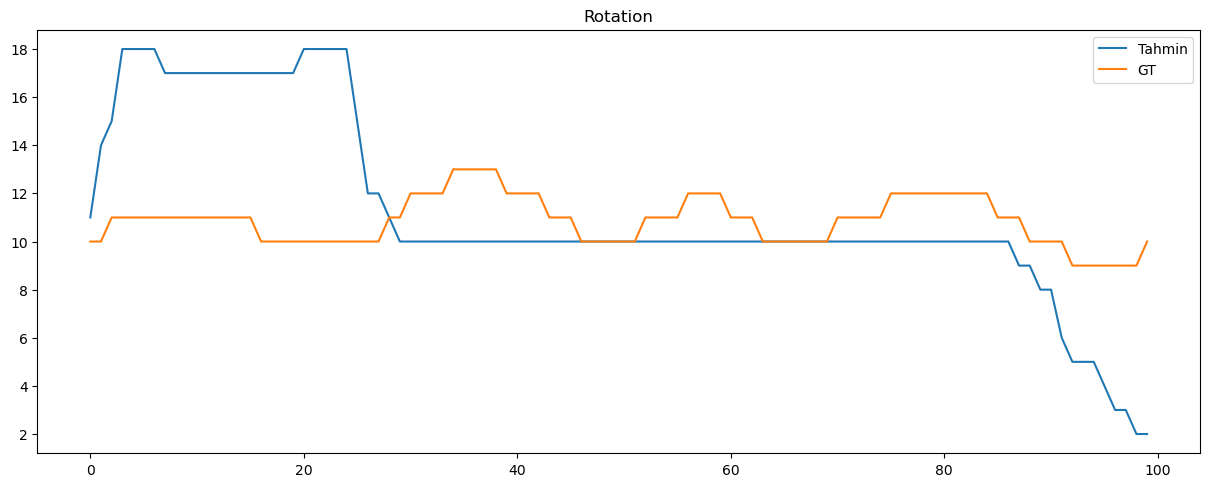

In [450]:
%matplotlib inline
plt.plot(np.argmax(prediction_train[1][30], axis=1),label="Tahmin")
plt.plot(np.argmax(tf.concat([i['rotation'] for i in y_train], axis=0)[30], axis=1), label="GT")

plt.title("Rotation")
#plt.xlim([0,50])

plt.legend()
plt.show()

In [451]:
%matplotlib qt
ax = plt.axes()

for i in range(prediction_train[0].shape[0]-1):
    ax.cla()
    ax.plot(np.argmax(prediction_train[1][i], axis=1),label="Tahmin")
    ax.plot(np.argmax(tf.concat([i['rotation'] for i in y_train], axis=0)[i], axis=1), label="GT")

    ax.set_title("Translation frame : " + str(i))
    #plt.xlim([0,50])

    ax.legend()
    plt.pause(0.0000000000001)
    plt.show()

In [452]:
X_test = list(map(lambda x: x[0], test_data))
y_test = list(map(lambda x: x[1], test_data))

In [453]:
predictions[0].shape

(6, 100, 21)

In [454]:
tf.concat([i['translation'] for i in y_test], axis=0)[0].shape

TensorShape([100, 21])

In [455]:
np.argmax(tf.concat([i['rotation'] for i in y_test], axis=0)[0], axis=1)

array([13, 13, 13, 12, 11, 11, 11, 11, 10,  9,  9,  8,  8,  7,  7,  7,  6,
        5,  5,  4,  4,  4,  3,  3,  3,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  3,  3,  4,  4,  5,  6,  7,  7,  8,  8,  9,  9, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
      dtype=int64)

In [456]:
np.argmax(predictions[0][0], axis=1)

array([19, 19, 19, 19, 19, 19, 19, 15, 15, 15, 15, 19, 19, 19, 19, 19, 19,
       19, 19, 19, 19, 19, 15, 15, 19, 19, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 14, 14, 14, 14, 15, 15, 14,
       12, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 11, 11, 11,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  7,  7,  7,  6,  6,  6,  6],
      dtype=int64)

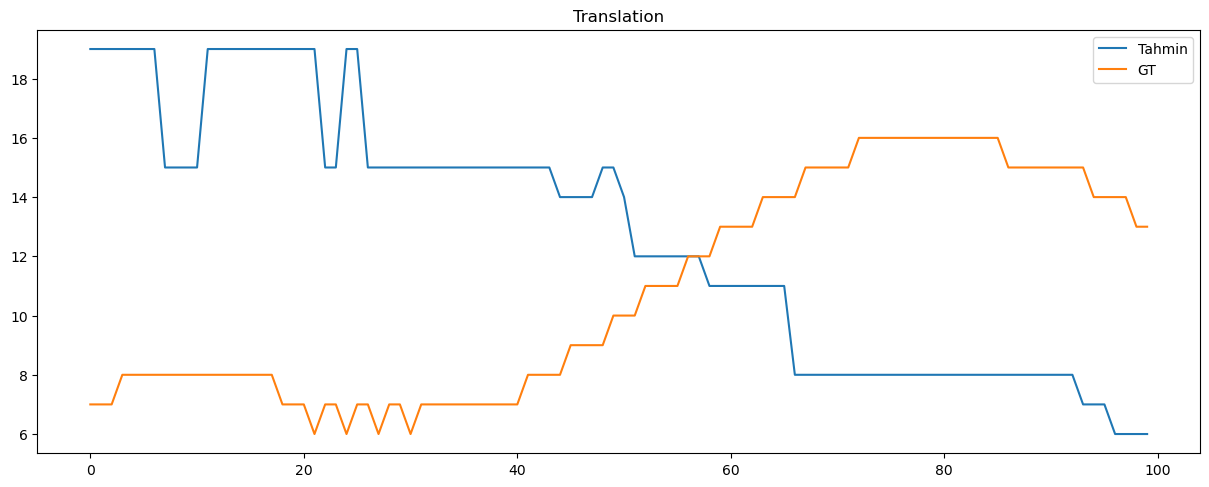

In [457]:
%matplotlib inline
plt.plot(np.argmax(predictions[0][0], axis=1),label="Tahmin")
plt.plot(np.argmax(tf.concat([i['translation'] for i in y_test], axis=0)[0], axis=1), label="GT")

plt.title("Translation")
#plt.xlim([0,50])

plt.legend()
plt.show()

In [458]:
%matplotlib qt
ax = plt.axes()

for i in range(predictions[0].shape[0]-1):
    ax.cla()
    ax.plot(np.argmax(predictions[0][i], axis=1),label="Tahmin")
    ax.plot(np.argmax(tf.concat([i['translation'] for i in y_test], axis=0)[i], axis=1), label="GT")

    ax.set_title("Translation frame : " + str(i))
    #plt.xlim([0,50])

    ax.legend()
    plt.pause(0.0000000000001)
    plt.show()

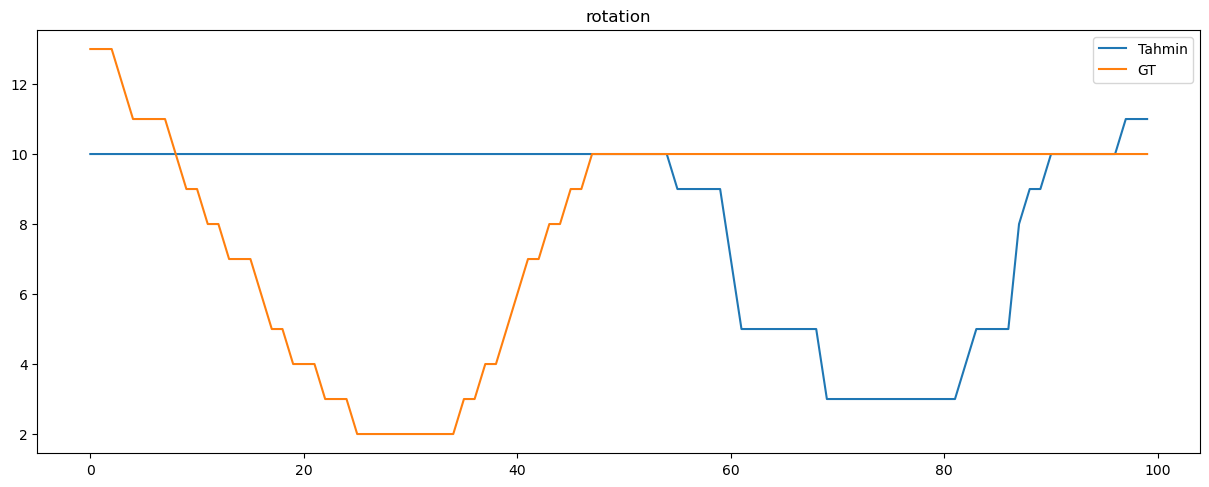

In [459]:
%matplotlib inline
plt.plot(np.argmax(predictions[1][0], axis=1),label="Tahmin")
plt.plot(np.argmax(tf.concat([i['rotation'] for i in y_test], axis=0)[0], axis=1), label="GT")
plt.legend()
#plt.xlim([0,10])
plt.title("rotation")
plt.show()

In [460]:
%matplotlib qt
ax = plt.axes()

for i in range(predictions[0].shape[0]-1):
    ax.cla()
    ax.plot(np.argmax(predictions[1][i], axis=1),label="Tahmin")
    ax.plot(np.argmax(tf.concat([i['rotation'] for i in y_test], axis=0)[i], axis=1), label="GT")

    ax.set_title("Translation frame : " + str(i))
    #plt.xlim([0,50])

    ax.legend()
    plt.pause(0.0000000000001)
    plt.show()

#  K-Fold CNN training

In [111]:
import numpy as np
import matplotlib.pyplot as plt
import pykitti
import math 
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import tensorflow as tf
def readBinDataset(filename):
    binDataset = np.load(filename)
    #print(bin)

    return binDataset

In [112]:
total_dataset_sz = 11
binDataset_ = []

In [113]:
#windows
for sequence in range(total_dataset_sz):
    binDataset_.append(readBinDataset(r"D:\Ara\numpy_dataset_sequences\%02d_angleBin.npy" % sequence))
    binDataset_[sequence]=binDataset_[sequence].reshape((len(binDataset_[sequence]), 3601,1 ))
    binDataset_[sequence] = np.array([ consec_frames for consec_frames in zip(binDataset_[sequence][0::], binDataset_[sequence][1::])])

# linux
#binDataset=readBinDataset("/mnt/d/Ara/numpy_dataset_sequences/%02d_angleBin.npy" % sequence)

In [114]:
len(binDataset_),  binDataset_[0].shape

(11, (4540, 2, 3601, 1))

In [115]:
from IPython.display import clear_output

%matplotlib inline
label_ = []
for sequence in range(total_dataset_sz):
    
    basedir = 'D:\\dataset\\'
    sequence_ = '%02d' % sequence
    dataset = pykitti.odometry(basedir, sequence_)
    
   
    x=np.array([])
    y=np.array([])
    z=np.array([])
    yaw=np.array([])

    fig = plt.figure(sequence)
    ax = fig.add_subplot(projection='3d' )
    ax.set_title(str(sequence))
    for i in range(len(dataset.poses)):
        x=np.append(x, [dataset.poses[i][0][3]])
        y=np.append(y, [dataset.poses[i][1][3]])
        z=np.append(z, [dataset.poses[i][2][3]])

    ax.scatter(x, y, z, marker='o')
    
    ax.view_init(-140, 60)
    plt.pause(0.1)
    plt.clf()

    t_xyz = np.c_[x, y, z]
    dt_xyz = t_xyz[1:] - t_xyz[0:-1]
    dt_xz = dt_xyz[:,[0,2]]
    translation_ = np.sqrt( dt_xz[:,0]** 2 +  dt_xz[:,1]**2)

    translation_ += 0.28 
    
    
    fig1 = plt.figure()
    yaw_=np.zeros(len(dataset.poses))
    for i in range(len(dataset.poses)):
        r= R.from_matrix([[dataset.poses[i][0][0], dataset.poses[i][0][1], dataset.poses[i][0][2]], [dataset.poses[i][1][0], dataset.poses[i][1][1], dataset.poses[i][1][2]], [dataset.poses[i][2][0], dataset.poses[i][2][1], dataset.poses[i][2][2]]])
        yaw=-r.as_rotvec()[1]
        yaw_[i]=yaw
    # plt.plot(np.rad2deg(yaw_))

    diff_pitch_ = -(yaw_[1::]-yaw_[:-1:])

    # outlier detection
    idxs = np.where((diff_pitch_>np.deg2rad(300)) | (diff_pitch_<np.deg2rad(-300)))

    diff_pitch_[idxs] =  diff_pitch_[idxs] - np.deg2rad(360)  * np.sign(diff_pitch_[idxs])

    label_.append(np.transpose(np.array((translation_,diff_pitch_))))
    
    plt.plot((np.rad2deg(diff_pitch_)))
    plt.pause(0.001)
    plt.clf()
#     plt.ylim([-4, 4])
#     plt.show()

clear_output(wait=True)

<Figure size 1500x550 with 0 Axes>

In [116]:
((len(label_)),binDataset_[0].shape, label_[0].shape)

(11, (4540, 2, 3601, 1), (4540, 2))

In [117]:
binDataset_ = np.array(binDataset_)
label_ = np.array(label_)

C:\Users\filiz\AppData\Local\Temp\ipykernel_4804\4136154583.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  binDataset_ = np.array(binDataset_)
C:\Users\filiz\AppData\Local\Temp\ipykernel_4804\4136154583.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  label_ = np.array(label_)


In [118]:
from sklearn.model_selection import KFold

In [119]:
num_folds = int(len(binDataset_) /2)
num_folds

5

In [120]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

verbosity = 1
no_epochs = 30
batch_size = 32

In [121]:
from keras import backend as K
import keras

def reset_weights(model):
    for layer in model.layers: 
        if isinstance(layer, tf.keras.Model):
            reset_weights(layer)
            continue
        for k, initializer in layer.__dict__.items():
            if "initializer" not in k:
                continue
            # find the corresponding variable
            var = getattr(layer, k.replace("_initializer", ""))
            var.assign(initializer(var.shape, var.dtype))

In [122]:
reset_weights(model)
keras.backend.clear_session()

c:\Users\filiz\anaconda3\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [123]:
fold_no = 1

In [124]:
acc_per_fold = []

In [125]:
loss_per_fold = []

In [126]:
def plotAngleBin(ax,angleBin):
    
    ax.scatter(0,0)
    xList = []
    yList = []
    for angle, bin in enumerate(angleBin):
        if bin > 0:
            y=bin*np.sin(np.deg2rad(angle*0.1))
            x=bin*np.cos(np.deg2rad(angle*0.1))
            xList.append(x)
            yList.append(y)
            # ax.scatter(x,y)
    ax.scatter(xList,yList)
    plt.pause(0.00000000000001)
    plt.show()

# K-Fold Eğitim için gerekli kütüphanelerin getirilmesi

In [127]:
import tensorflow as tf

In [180]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import concatenate
from keras.layers import TimeDistributed
from keras.layers import LSTM
np.random.seed(16)
tf.random.set_seed(16)

In [129]:
input_layer = tf.keras.layers.Input(shape=(2,3601,1))

In [130]:
model1 = Dense(512, activation='relu')(model(input_layer))
model2 = Dense(512, activation='relu')(model(input_layer))

model1 = Dropout(0.3) (model1)
model2 = Dropout(0.3) (model2)


model1 = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-3))(model1)
model2 = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-3))(model2)

model1 = Dropout(0.2) (model1)
model2 = Dropout(0.2) (model2)

# model1 = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-3))(model1)
# model2 = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-3))(model2)

# model1 = tf.keras.layers.Dropout(0.2) (model1)
# model2 = tf.keras.layers.Dropout(0.2) (model2)

model1 = Dense(21, name="translation",activation='softmax')(model1) # translate
model2 = Dense(21, name="rotation",activation='softmax')(model2) # yaw

# model1 = tf.keras.layers.Activation('softmax', name="translation")(model1)
# model2 = tf.keras.layers.Activation('softmax', name="rotation")(model2)

kfold_cnn_model = tf.keras.Model(inputs=[input_layer], outputs=[model1, model2])

kfold_cnn_model.compile(loss = 'categorical_crossentropy',
              optimizer='adam',
              metrics = ['accuracy'])

In [131]:
def binOutput(label, sample_sz):
    t_bin = np.zeros(sample_sz)
    r_bin = np.zeros(sample_sz)

    interval = sample_sz-1

    t_bin = np.zeros(sample_sz)
    r_bin = np.zeros(sample_sz)
    labelBinned = np.array([[t_bin,r_bin]])
    for data in label:
        t_bin = np.zeros(sample_sz)
        r_bin = np.zeros(sample_sz)
        t_bin[int(((data[0]*interval)))] = 1
        r_bin[int(((data[1]*interval)))] = 1
        
        labelBinned = np.concatenate([labelBinned, np.array([np.array([t_bin, r_bin])])], axis=0)
    return labelBinned[1:]

In [132]:
from sklearn.preprocessing import MinMaxScaler
unscaled_label_data = np.concatenate(label_, axis=0)
scaler = MinMaxScaler()
scale = scaler.fit(unscaled_label_data)


In [133]:
reset_weights(kfold_cnn_model)
keras.backend.clear_session()
for train, test in kfold.split(binDataset_, label_):
    train_data_ = np.concatenate(binDataset_[train], axis=0)
    train_label_ = np.concatenate(label_[train], axis=0)
    

    label = scaler.transform(train_label_)
    labelBinned = binOutput(label,21)

    translation = labelBinned[:,0,:]
    rotation = labelBinned[:,1,:]
    dataset_ = tf.data.Dataset.from_tensor_slices((train_data_, {"translation": translation, "rotation" : rotation}))
    full_dataset_ = dataset_.shuffle(buffer_size=100).batch(batch_size=batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

    history=kfold_cnn_model.fit(full_dataset_,
              epochs=no_epochs,
              verbose=verbosity)
    

    test_data_ = np.concatenate(binDataset_[test], axis=0)
    test_label_ = np.concatenate(label_[test], axis=0)
    
    label = scaler.transform(test_label_)
    labelBinned = binOutput(label,21)

    translation = labelBinned[:,0,:]
    rotation = labelBinned[:,1,:]
    test_label_data = {"translation": translation, "rotation" : rotation}

    # Generate generalization metrics
    scores = kfold_cnn_model.evaluate(test_data_, test_label_data, verbose=0)
    print(f'Score for fold {fold_no}: {kfold_cnn_model.metrics_names[-2]} of {scores[-2]}; {kfold_cnn_model.metrics_names[-1]} of {scores[-1]}')
    acc_per_fold.append(scores[-2])
    loss_per_fold.append(scores[-1])
    fold_no = fold_no + 1

    

c:\Users\filiz\anaconda3\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/30
403/403 [==============================] - 22s 38ms/step - loss: 4.3783 - translation_loss: 2.3580 - rotation_loss: 1.6442 - translation_accuracy: 0.2192 - rotation_accuracy: 0.5763
Epoch 2/30
403/403 [==============================] - 15s 37ms/step - loss: 3.8737 - translation_loss: 2.2376 - rotation_loss: 1.4710 - translation_accuracy: 0.2139 - rotation_accuracy: 0.5816
Epoch 3/30
403/403 [==============================] - 14s 35ms/step - loss: 3.6962 - translation_loss: 2.1613 - rotation_loss: 1.4122 - translation_accuracy: 0.2332 - rotation_accuracy: 0.5869
Epoch 4/30
403/403 [==============================] - 14s 34ms/step - loss: 3.7001 - translation_loss: 2.1940 - rotation_loss: 1.4060 - translation_accuracy: 0.2349 - rotation_accuracy: 0.5913
Epoch 5/30
403/403 [==============================] - 14s 34ms/step - loss: 3.5143 - translation_loss: 2.0925 - rotation_loss: 1.3251 - translation_accuracy: 0.2589 - rotation_accuracy: 0.5968
Epoch 6/30
403/403 [===============

# Save Pretrained CNN Model

In [178]:
# serialize model to JSON
model_json = kfold_cnn_model.to_json()
with open("kfold_cnn_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
kfold_cnn_model.save_weights("kfold_cnn_model.h5")
print("Saved model to disk")

Saved model to disk


# Load PreTrained CNN Model

In [181]:
# load json and create model
json_file = open('kfold_cnn_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("kfold_cnn_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [183]:
loaded_model.compile(loss = 'categorical_crossentropy',
              optimizer='adam',
              metrics = ['accuracy'])

In [184]:

label = scaler.transform(test_label_)
labelBinned = binOutput(label,21)

translation = labelBinned[:,0,:]
rotation = labelBinned[:,1,:]
test_label_data = {"translation": translation, "rotation" : rotation}

# Generate generalization metrics
scores = loaded_model.evaluate(test_data_, test_label_data, verbose=0)
scores

[1.5088716745376587,
 1.1226654052734375,
 0.27420973777770996,
 0.774193525314331,
 0.9329749345779419]

In [135]:
def plotAngleBin(ax,angleBin):
    ax.cla()
    ax.scatter(0,0)
    xList = []
    yList = []
    for angle, bin in enumerate(angleBin):
        if bin > 0:
            y=bin*np.sin(np.deg2rad(angle*0.1))
            x=bin*np.cos(np.deg2rad(angle*0.1))
            xList.append(x)
            yList.append(y)
            # ax.scatter(x,y)
    ax.scatter(xList,yList)
    plt.pause(0.00000000000001)
    plt.show()

In [136]:
train_batch = full_dataset_.as_numpy_iterator()
example_trained_data = train_batch.next()
example_trained_data[0].shape # input
print(example_trained_data[1]['translation'].shape, example_trained_data[1]['rotation'].shape)
example_bin_input = example_trained_data[0]
example_bin_output_translation= example_trained_data[1]['translation']
example_bin_output_rotation = example_trained_data[1]['rotation']


%matplotlib qt
# %matplotlib inline
fig, axs = plt.subplots(2)
axs[0].set_aspect('equal', adjustable='box')
axs[1].set_aspect('equal', adjustable='box')

for i in range(len(example_trained_data[0])):
    fig.suptitle("Batch verisi")
    text = fig.text(0.1, 0.1,"translation:{translation} rotation:{rotation} ".format(translation=np.argmax(example_bin_output_translation[i]), rotation=np.argmax(example_bin_output_rotation[i])))
    plotAngleBin(axs[0], example_bin_input[i][0])
    
    plotAngleBin(axs[1], example_bin_input[i][1])
    text.remove()
    
    # print(example_bin_input_time_distributed[i][0] == example_bin_input_time_distributed[i][1])


(32, 21) (32, 21)


# Tek tek değerlendir

In [157]:
X_test = list(map(lambda x: x[0], test_data_))
y_test = list(map(lambda x: x[1], test_label_data['translation'])) 

In [139]:
predictions = kfold_cnn_model.predict(test_data_)

88/88 [==============================] - 3s 14ms/step


In [164]:
predictions[0].shape, test_label_data['translation'].shape

((2790, 21), (2790, 21))

In [175]:
fig, axs = plt.subplots(2)
axs[0].set_aspect('equal', adjustable='box')
axs[1].set_aspect('equal', adjustable='box')
  
for i in range(len(test_label_data['translation'])):
    axs[0].cla()
    axs[1].cla()

    axs[0].plot(predictions[0][i],label="Tahmin")
    axs[1].plot(test_label_data['translation'][i], label="GT")
    
    plt.title("Translation")
    plt.legend()
    plt.pause(0.0000000001)
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

KeyboardInterrupt: 

In [82]:
plt.plot(predictions[1], label="Tahmin")
plt.plot(tf.concat(y_test,0)[:,1], label="GT")
plt.legend()
#plt.xlim([0,10])
plt.title("rotation")
plt.show()

NameError: name 'predictions' is not defined

# Example CNN LSTM architecture

CNN Model

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import concatenate
from keras.layers import TimeDistributed
from keras.layers import LSTM

In [ ]:
tf.config.list_physical_devices('GPU')

In [ ]:
from numpy import zeros, array
from random import randint
from random import random
from matplotlib import pyplot

# generate the next frame in the sequence
def next_frame(last_step, last_frame, column):
    # define the scope of the next step
    lower = max(0, last_step-1)
    upper = min(last_frame.shape[0]-1, last_step+1)
    # choose the row index for the next step
    step = randint(lower, upper)
    # copy the prior frame
    frame = last_frame.copy()
    # add the new step
    frame[step, column] = 1
    return frame, step
# generate a sequence of frames of a dot moving across an image
def build_frames(size):
    frames = list()
    # create the first frame
    frame = zeros((size,size))
    step = randint(0, size-1)
    # decide if we are heading left or right
    right = 1 if random() < 0.5 else 0
    col = 0 if right else size-1
    frame[step, col] = 1
    frames.append(frame)
    # create all remaining frames
    for i in range(1, size):
        col = i if right else size-1-i
        frame, step = next_frame(step, frame, col)
        frames.append(frame)
    return frames, right



In [ ]:
# generate sequence of frames
size = 5
frames, right = build_frames(size)

In [ ]:
# plot all feames
pyplot.figure()
for i in range(size):
    # create a grayscale subplot for each frame
    pyplot.subplot(1, size, i+1)
    pyplot.imshow(frames[i], cmap= 'Greys' )
    # turn of the scale to make it cleaer
    ax = pyplot.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # show the plot
    pyplot.show()

Generate Dataset

In [ ]:
# generate multiple sequences of frames and reshape for network input
def generate_examples(size, n_patterns):
    X, y = list(), list()
    for _ in range(n_patterns):
        frames, right = build_frames(size)
        X.append(frames)
        y.append(right)
    # resize as [samples, timesteps, width, height, channels]
    X = array(X).reshape(n_patterns, size, size, size, 1)
    y = array(y).reshape(n_patterns, 1)
    return X, y

# Model

define the model


In [ ]:
# configure problem
size = 50
# define the model
model = Sequential()
model.add(TimeDistributed(Conv2D(2, (2,2), activation= 'relu' ),
input_shape=(None,size,size,1)))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50))
model.add(Dense(1, activation= 'sigmoid' ))
model.compile(loss= 'binary_crossentropy' , optimizer= 'adam' , metrics=[ 'acc' ])
print(model.summary())

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

fit model

In [ ]:
X, y = generate_examples(size, 5000)
model.fit(X, y, batch_size=32, epochs=1)

evaluate model

In [ ]:
y

In [ ]:
X, y = generate_examples(size, 100)
loss, acc = model.evaluate(X, y, verbose=0)
print( "loss: %f, acc: %f " % (loss, acc*100))

prediction on new data

In [ ]:
X, y = generate_examples(size, 1)
# yhat = model.predict_classes(X, verbose=0)
yhat = (model.predict(X) > 0.5).astype("int32")
expected = "Right" if y[0]==1 else "Left"
predicted = "Right" if yhat[0]==1 else "Left"
print( "Expected: %s, Predicted: %s" % (expected, predicted) )

Image Initialization

In [ ]:
from numpy import zeros
frame = zeros((10,10))

In [ ]:
from random import randint
step = randint(0, 10-1)

In [ ]:
from random import random
right = 1 if random() < 0.5 else 0
col = 0 if right else 9

In [ ]:
frame[step, col] = 1

Adding Steps

In [ ]:
lower = max(0, last_step-1)
upper = min(10-1, last_step+1)
step = randint(lower, upper)


In [ ]:
column = i if right else size-1-i
frame = last_frame.copy()
frame[step, column] = 1

# tüm labelları oku ve min max scaling yap

minimum ve maksimum labellı verileri tüm veri seti içerisinden bul.

In [ ]:
import pykitti
import numpy as np
total_dataset_sz = 11

In [ ]:
for sequence in range(total_dataset_sz):
    basedir = 'D:\\dataset\\'
    sequence_ = '%02d' % sequence
    dataset = pykitti.odometry(basedir, sequence_)
    
   
    x=np.array([])
    y=np.array([])
    z=np.array([])
    yaw=np.array([])

 
    t_xyz = np.c_[x, y, z]
    dt_xyz = t_xyz[1:] - t_xyz[0:-1]
    dt_xz = dt_xyz[:,[0,2]]
    translation_ = np.sqrt( dt_xz[:,0]** 2 +  dt_xz[:,1]**2)

    translation_ += 0.28 
    
    
    
    yaw_=np.zeros(len(dataset.poses))
    for i in range(len(dataset.poses)):
        r= R.from_matrix([[dataset.poses[i][0][0], dataset.poses[i][0][1], dataset.poses[i][0][2]], [dataset.poses[i][1][0], dataset.poses[i][1][1], dataset.poses[i][1][2]], [dataset.poses[i][2][0], dataset.poses[i][2][1], dataset.poses[i][2][2]]])
        yaw=-r.as_rotvec()[1]
        yaw_[i]=yaw
    # plt.plot(np.rad2deg(yaw_))

    diff_pitch_ = -(yaw_[1::]-yaw_[:-1:])

    # outlier detection
    idxs = np.where((diff_pitch_>np.deg2rad(300)) | (diff_pitch_<np.deg2rad(-300)))

    diff_pitch_[idxs] =  diff_pitch_[idxs] - np.deg2rad(360)  * np.sign(diff_pitch_[idxs])

    label_.append(np.transpose(np.array((translation_,diff_pitch_))))
    


In [ ]:
binDataset_[0].shape, label_[0].shape

# classificationa örnekle

In [ ]:
from time import time
import numpy as np
import matplotlib.pyplot as plt


# Odometri Sonucunu Çizdir

# Modeli Ubuntuya Göndermek İçin Kaydet

# Laser verisini gazebodan al

# Laser verisini kutula ve modele değerlendirme olarak at

# Çıkan sonuçtan artımlı odometri çiz

# Deterministik Modeli Kur ve Karşılaştır